# Using DoWhy for Causal Inference in Observational Data

## Intro

This notebook aims to demonstrate the capabilites of using the Causal Framework to infer causal relationships from observational data, and the tools we have available to validate our conclusions, all of them powered by [Microsoft's DoWHy package](https://github.com/Microsoft/dowhy#id11).

First, let us add the required path for Python to find the DoWhy code and load all required packages.

### Loading Packages and Dependencies

In [2]:
#import os, sys
#sys.path.append(os.path.abspath("../../../"))

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
# dowhy framework
import dowhy
import dowhy.api
from dowhy import CausalModel
import dowhy.datasets
from dowhy.do_samplers.weighting_sampler import WeightingSampler

## Classical Binary Treatment Case and DoWhy Possibilities

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, common causes and outcome, and binary treatment on continuous outcome. (Obs.: beta is the true causal effect. )

In [8]:
data = dowhy.datasets.linear_dataset(
    beta=10 # causal coef
    , num_common_causes=7 # cofounders
    , num_instruments = 2 #vi
    , num_treatments=1 # treatment
    , num_samples=10000 # sample
    , treatment_is_binary=True
    , outcome_is_binary=False
)
df = data["df"]
df.head()

,Z0,Z1,W0,W1,W2,W3,W4,W5,W6,v0,y
0,0.0,0.313718,-0.353159,1.573242,1.167338,-1.270361,0.972638,1.216200,-0.143037,True,25.378387
1,1.0,0.285723,0.711820,0.534953,0.581607,-1.098508,1.581972,-0.606891,0.924611,True,17.637897
2,1.0,0.747737,1.257279,0.322854,-0.087815,1.097296,-1.306569,0.083018,-1.140140,True,7.503461
3,1.0,0.673285,0.805833,0.008666,1.681053,-0.313155,1.776789,-0.941223,-0.483612,True,14.636521
4,0.0,0.134164,0.477748,0.097975,1.150387,0.419858,1.210495,-0.370777,3.004295,True,29.761448


## Data Exploration

A few brief exploration on the synthetic dataset to understand how it looks like

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Z0      10000 non-null  float64
 1   Z1      10000 non-null  float64
 2   W0      10000 non-null  float64
 3   W1      10000 non-null  float64
 4   W2      10000 non-null  float64
 5   W3      10000 non-null  float64
 6   W4      10000 non-null  float64
 7   W5      10000 non-null  float64
 8   W6      10000 non-null  float64
 9   v0      10000 non-null  bool   
 10  y       10000 non-null  float64
dtypes: bool(1), float64(10)
memory usage: 791.1 KB


In [5]:
# Unbeliavable to check how corr changes nothing with the treatment having or not causal impact 
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Z0,Z1,W0,W1,W2,W3,W4,W5,W6,v0,y
Z0,1.000000,-0.007829,0.008773,-0.014901,-0.014220,-0.006646,0.005577,-0.004712,0.003365,0.162369,0.049351
Z1,-0.007829,1.000000,-0.000658,0.005153,-0.011391,-0.013721,-0.014710,0.001056,-0.008902,0.206644,0.070045
W0,0.008773,-0.000658,1.000000,0.011453,0.004680,0.000002,-0.010121,0.013356,0.009672,0.291642,0.181924
W1,-0.014901,0.005153,0.011453,1.000000,0.021270,-0.003254,-0.009167,0.008899,0.007068,0.168553,0.297541
W2,-0.014220,-0.011391,0.004680,0.021270,1.000000,-0.003982,-0.004642,0.000181,0.004074,0.107218,0.532694
W3,-0.006646,-0.013721,0.000002,-0.003254,-0.003982,1.000000,0.010193,0.031829,0.018415,0.033358,0.048241
W4,0.005577,-0.014710,-0.010121,-0.009167,-0.004642,0.010193,1.000000,-0.009106,0.001847,0.062584,0.129853
W5,-0.004712,0.001056,0.013356,0.008899,0.000181,0.031829,-0.009106,1.000000,-0.005054,0.245483,0.672394
W6,0.003365,-0.008902,0.009672,0.007068,0.004074,0.018415,0.001847,-0.005054,1.000000,-0.008463,0.154425
v0,0.162369,0.206644,0.291642,0.168553,0.107218,0.033358,0.062584,0.245483,-0.008463,1.000000,0.628938


As seen above, the cofounders have rasonable relationships both with intervention 'v0' and outcome 'y', and the intruments 'z's' only owns relationship with v0, then the synthetic data generator looks to be working as expected.

### Naivy Approach

The naivy approach to discover the Average Treatment Effect (ATE) of an intervention would be to calculate the difference on outcome average under treatment and control (and it's what actually happens when dealing with randomized data). However the data isn't randomized and it's already know both intervention as outcomes owns cofundoers who affects the probability of receiving the treatment as the outcome value itself.

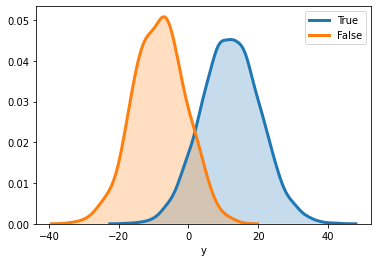

In [9]:
# number of uniqeu interventions
interventions = df.v0.unique()

# Iterate through the five airlines
for intervention in interventions:
    # Subset to the airline
    subset = df[df['v0'] == intervention]
    
    # Draw the density plot
    sns.distplot(
        subset['y'], hist = False, kde = True
        , kde_kws = {'shade': True, 'linewidth': 3}
        , label = intervention
    )
    
# Plot formatting
#plt.legend(prop={'size': 16}, title = 'Airline')
#plt.title('Density Plot with Multiple Airlines')
#plt.xlabel('Delay (min)')
#plt.ylabel('Density')

In [22]:
naivy_estimate = df[df.v0==1]['y'].mean() - df[df.v0==0]['y'].mean()
print('The Naivy ATE is: %f' % naivy_estimate)

The Naivy ATE is: 16.831265


## Causal Framework

DoWhy is based on a simple unifying language for causal inference. Causal inference may seem tricky, but almost all methods follow four key steps:

1. Model a causal inference problem using assumptions.
2. Identify an expression for the causal effect under these assumptions ("causal estimand").
3. Estimate the expression using statistical methods such as matching or instrumental variables.
4. Finally, verify the validity of the estimate using a variety of robustness checks.


This workflow can be captured by four key verbs in DoWhy:

* model
* identify
* estimate
* refute

### **Model** Phase - input the "graph"

Assumptions are first-class citizens in DoWhy. Each analysis starts with a building a causal model. The assumptions can be viewed graphically or in terms of conditional independence statements. This serves to make each causal assumption explicit. This graph doesn't need to be complete - you can provide a partial graph, representing prior knowledge about some of the variables.

In [3]:
# With graph
model=CausalModel(
    data = df
    , treatment=data["treatment_name"]
    , outcome=data["outcome_name"]
    , common_causes=data["common_causes_names"] # both works the same, but the first is based on a previous graph
    , instruments=data["instrument_names"]
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


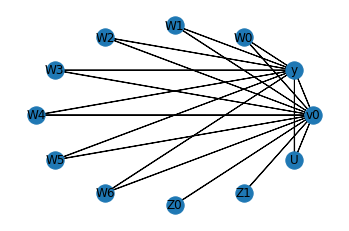

In [9]:
# it doesn't work properly on newer python versions (3.6+)
model.view_model()

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify 
the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

**DoWhy philosophy: Keep identification and estimation separate**

Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step.
It is important to understand that these are orthogonal steps.

### Identification Phase

Based on the causal graph, DoWhy finds all possible ways of identifying a desired causal effect based on the graphical model. It uses graph-based criteria and do-calculus to find potential ways find expressions that can identify the causal effect.

Describe a little better the object output here

In [4]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W3', 'W6', 'W2', 'W5', 'W4', 'U', 'W1', 'W0']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W3,W6,W2,W5,W4,W1,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W6,W2,W5,W4,W1,W0,U) = P(y|v0,W3,W6,W2,W5,W4,W1,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



### Estimation Phase

Identification is the causal problem. Estimation is simply a statistical problem.
DoWhy respects this boundary and treats them separately. All dowhy's built-in estimation methods are briefly explained on this [presentation](https://causalinference.gitlab.io/kdd-tutorial/).
Fundamentally, it's recommended to test at least two different methods to have more confidence on the effect. Here, we'll examine all DoWhy methods.

Describe a little better the object output here

#### Conditional Based Methods

Conditioning-based methods are the workhorse of causal inference when running active experiments is not feasible. The approach here is to calculate treatment effect by identifying groups of individuals with the same (or similar) covariates on both control and treratment, aiming to neutralize the dependence between treatment and cofounders (then simulating the randomized perfect environment).  

##### Propensity Score Matching

Matching calculates the treatment effect by identifying pairs of similar individuals based on its covariates, where one is treated and the other not. The great caviat on this procedure is with the mathing method,  how to equilibrate bias / variance when matching the pairs, or dropping observations without mathcing, and model dependence if using propensity score models (as it is here).

In [14]:
causal_estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_matching"
)
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 16.04709499950085



#### Propensity-based Stratification

Based on a similar approach as matching, stratification tries to generalizes the above concept by divigin the observations into stratas based on covariates balance, instead of 1:1 matchs. However this might introduce new caveats: the risk of being too generalist at some stratas, leading to less meaningfull associations, or creating stratas with too fews subjects.

In [13]:
causal_estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_stratification"
)
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 10.252676484347129



#### Inverse Propensity Weighting

Similarly to the above one, it tries to neutralize the covaritates influence on treatment by assigning the probability of being treated, however, instead of using stratas or matchings, this process tries to directly weight the outcomes by a combination inversely proportional to the probability of being treated. The caveats regarding this method lies mainly when dealing with extreme values on the propensity score due to the higher variance generate on the weights by them.

DoWhy supports a few different weighting schemes:
1. Vanilla Inverse Propensity Score weighting (IPS) (weighting_scheme="ips_weight")
2. Self-normalized IPS weighting (also known as the Hajek estimator) (weighting_scheme="ips_normalized_weight")
3. Stabilized IPS weighting (weighting_scheme = "ips_stabilized_weight")

In [7]:
causal_estimate = model.estimate_effect(
    identified_estimand
    , method_name="backdoor.propensity_score_weighting"
    , target_units = "ate"
    , method_params={"weighting_scheme":"ips_normalized_weight"}
)
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W6+W2+W5+W4+W1+W0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W3,W6,W2,W5,W4,W1,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W6,W2,W5,W4,W1,W0,U) = P(y|v0,W3,W6,W2,W5,W4,W1,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W6+W2+W5+W4+W1+W0
## Estimate
Value: 13.518669054400416



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Linear Regression

The most classical approach, it's resumed in fitting a linear regression into covariates, treatment and outcome and the treatment regression coefficient will measure the ATE. However using this approach is **very inadvisable** as it's very susceptible to be invalidated due to it's rigid assumptions (model correctness, multicolinearity and ignorability).

In [12]:
causal_estimate = model.estimate_effect(
    identified_estimand,method_name="backdoor.linear_regression"
)
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 9.999999999999964



#### Intrumental Variables Methods

More related to the "Quasi-experiments" approach, Intrumental Variable methods introduce "as if random" noise to the treatment assignment.

##### Binary Instrument/Wald Estimator

This is the classical IV approach, it's based on the intrument's lack of correlation to both cofounders and outcomes, but to the treatment assignment. The greatest caveat here is the possibility of not generalizing well to the whole population.

In [16]:
causal_estimate = model.estimate_effect(
    identified_estimand,method_name="iv.instrumental_variable"
    , method_params = {'iv_instrument_name': ['Z0']}
)
print(causal_estimate)

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common causes of ['v0'] and y



*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2,

##### Regression Discontinuity

Instead of an IV influencing the distribution of treatment over individuals, this method is based on arbitraty changes to decide the treated ones arbitrally (thought an abrupte cutt off). The racional here is: people near the threshold are very similar to each other both on treatment and control, "as if random" assigned to each "side". The caveat is the effect estimation only on the boundary, so it might generalize so well to the whole data.


(Worth to mention this design wouldn't be suited to the synthetic dataset chosen for this demonstration) 

In [17]:
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.regression_discontinuity", 
    method_params={
        'rd_variable_name':'Z1'
        , 'rd_threshold_value':0.5
        , 'rd_bandwidth': 0.1
    }
)
print(causal_estimate)

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(y, local_rd_variable))⋅Expectation(Derivative(v0, local

              -1
_rd_variable))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome is affected in the same way by common causes of ['local_treatment'] and local_outcome



      local_rd_variable  local_treatment  local_outcome
17             0.587663             True      16.735838
32             0.558842             True       4.235377
42             0.528779             True      22.030615
43             0.582572             True      16.139430
45             0.586549             True       2.934968
...                 ...              ...            ...
9969           0.437027             True       2.489741
9978           0.513033             True      14.086854
9980           0.489366             True      29.300886
9990           0.486356             True       7.368931
9995           0.591452             True      18.760037

[1988 rows x 3 columns]
*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfounded

### Refuting Phase

Lastly, the package offers [automated robustness checks](https://www.r-bloggers.com/dowhy-library-exploration/) as well. The most critical, and often skipped, part of causal analysis is checking the robustness of estimates to unverified assumptions. DoWhy makes it easy to automatically run sensitivity and robustness checks on the obtained estimate.

To test the robustness methods, let's create a an estimated object just for this purpose.

In [13]:
estimate_to_refute = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_stratification"
)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W6+W2+W5+W4+W1+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Adding a random common cause variable

If the estimation is robust, adding a random covariate shouldn't affect it. This means the sample size is probably large enough to accommodate further confounders without loss of accuracy.

In [20]:
res_random=model.refute_estimate(
    identified_estimand, estimate_to_refute
    , method_name="random_common_cause", random_seed = 667
)
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0+w_random


Refute: Add a Random Common Cause
Estimated effect:(10.252676484347129,)
New effect:(10.280796680941915,)



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Replacing treatment with a random (placebo) variable (A/A Test)

Random assign outcome to both treatment and control should neutralize any treatment effect.

In [14]:
res_placebo=model.refute_estimate(
    identified_estimand, estimate_to_refute, random_seed = 667
    , method_name="placebo_treatment_refuter", placebo_type="permute"
)
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+W6+W2+W5+W4+W1+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a Placebo Treatment
Estimated effect:(9.665820090076354,)
New effect:(0.49186638394364723,)



#### Removing a random subset of the data

If the estimation is robust, the treatment effect shouldn't vary too much thourgh data subsets.

In [23]:
res_subset=model.refute_estimate(
    identified_estimand, estimate_to_refute, random_seed = 667
    , method_name="data_subset_refuter", subset_fraction=0.9
)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a subset of data
Estimated effect:(10.252676484347129,)
New effect:(10.520028319997916,)



#### Adding an unobserved common cause variable (sensitivity analysis)

How sensitive is the estimation to minor vilations of the assumptions? How big should be the effect of a confounder to be able to reverse the estimation sign? let’s test the unconfoundness hypothesis by running a simulation to add the effect of unknown confounders. **Domain Knowledge helps to guide reasonable values to this simulations**.


The effect_strength_on_treatment and effect_strength_on_outcome arguments denote the confounder's coefficient on treatment or outcome. If it's set to "binary_flip", it'll be the probability of the confounder flipping the treatment/outcome from 0 to 1 (or vice verca); or if it's set to "linear", it'll be the linear coefficient of the confounder on the treatment/outcome. This selection will depend on the treatment/outcome nature (it it's binary or continuos).

##### First test: minimal magnitude unkown confounder

In [18]:
res_unobserved_minimal=model.refute_estimate(
    identified_estimand, estimate_to_refute, method_name="add_unobserved_common_cause"
    , confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear"
    , effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.01, random_seed = 667
)
print(res_unobserved_minimal)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W6+W2+W5+W4+W1+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Add an Unobserved Common Cause
Estimated effect:(9.665820090076354,)
New effect:(8.954236678973386,)



##### First test: reasonable magnitude unkown confounder

In [20]:
res_unobserved_reasonable=model.refute_estimate(
    identified_estimand, estimate_to_refute, method_name="add_unobserved_common_cause"
    , confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear"
    , effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.05, random_seed = 667
)
print(res_unobserved_reasonable)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W6+W2+W5+W4+W1+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Add an Unobserved Common Cause
Estimated effect:(9.665820090076354,)
New effect:(4.209078078723106,)



## Other Package Interesting Funcionality

* Heterogeneous Treatment Estimation Support

You can input additional parameters to the estimate_effect method. For instance, to estimate the effect on any subset of the units, you can specify the "target_units" parameter which can be a string ("ate", "att", or "atc"), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. You can also specify "effect modifiers" to estimate heterogeneous effects across these variables. See `help(CausalModel.estimate_effect)`. 

In [18]:
# Causal effect on the control group (ATC)
causal_estimate_atc = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_atc)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W4+W5+W1+W2+W3+W6+W0
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W4,W5,W1,W2,W3,W6,W0))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W5,W1,W2,W3,W6,W0,U) = P(y|v0,W4,W5,W1,W2,W3,W6,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W4+W5+W1+W2+W3+W6+W0
## Estimate
Value: 10.354852941146467



### Do Sampler

Add brief theoretical explanation of what it is, Ts and Bs

In [11]:
do_df=(
    df
    .causal.do(
        x='v0',outcome='y',common_causes=[ 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']
        ,variable_types={
            'v0':'b','y':'c','W0':'c', 'W1':'c', 'W2':'c'
            , 'W3':'c', 'W4':'c', 'W5':'c', 'W6':'c'
        }
    )
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W3', 'U', 'W6', 'W2', 'W1', 'W4', 'W0', 'W5']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  


Please respond with 'y' or 'n'


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


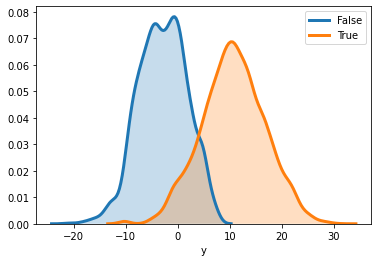

In [12]:
# 
interventions = do_df.v0.unique()

# Iterate through the five airlines
for intervention in interventions:
    # Subset to the airline
    subset = do_df[do_df['v0'] == intervention]
    
    # Draw the density plot
    sns.distplot(subset['y'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = intervention)

In [23]:
do_causal_estimate = do_df[do_df.v0==1]['y'].mean() - do_df[do_df.v0==0]['y'].mean()
print('The Do Calculus ATE is: %f' % do_causal_estimate)

The Do Calculus ATE is: 13.553620
